In [1]:
from causalsim import *
import metrics
from econml.metalearners import XLearner
from econml.dr import DRLearner
from econml.dml import CausalForestDML
from econml.metalearners import TLearner
from econml.metalearners import SLearner
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Data Generation 
#### Simple model: Treatment effect for individual i: \tau_i = \beta * x_{i1} 

In [47]:
n = 10000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data = simulation_simple(n = n, p = p, beta = beta, sigma = sigma)
print(data.head(10))

         X1       tau  Z   epsilon         Y
0  0.405646  0.405646  1 -1.975248 -1.569602
1 -1.023865 -1.023865  1  0.703547 -0.320318
2  1.292923  1.292923  0 -1.045015 -1.045015
3 -1.084910 -1.084910  1  0.588445 -0.496466
4 -1.234277 -1.234277  0 -0.558988 -0.558988
5 -2.373829 -2.373829  1 -1.993617 -4.367446
6  0.038363  0.038363  0  0.338073  0.338073
7 -0.636002 -0.636002  0  2.551784  2.551784
8  0.414325  0.414325  0  0.194741  0.194741
9 -1.096922 -1.096922  0 -1.187006 -1.187006


#### Categorical Model

In [43]:
n = 1000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data_cat = simulation_categorical(n = n, p = p, beta = beta, sigma = sigma)
print(data_cat.head(10))

         X1  tau  Z   epsilon         Y
0  0.111257    1  0 -1.681830 -1.681830
1 -0.585010    0  1  0.171507  0.171507
2  0.527253    1  0 -0.514185 -0.514185
3 -0.978218    0  0 -1.123768 -1.123768
4  0.808458    1  0 -1.389095 -1.389095
5  1.134954    1  0  1.133672  1.133672
6 -0.902571    0  0  0.070411  0.070411
7 -0.920190    0  1 -1.650820 -1.650820
8 -0.995926    0  0 -1.147429 -1.147429
9 -0.379050    0  1 -0.536784 -0.536784


#### Assigning variables for econml metalearner functions

In [48]:
X = data[[col for col in data.columns if col.startswith('X')]]
T = data['Z'] #treatment indicator
y = data['Y']
tau = np.array(data['tau'])

## Linear Regression

#### y ~ X + Z + X*Z

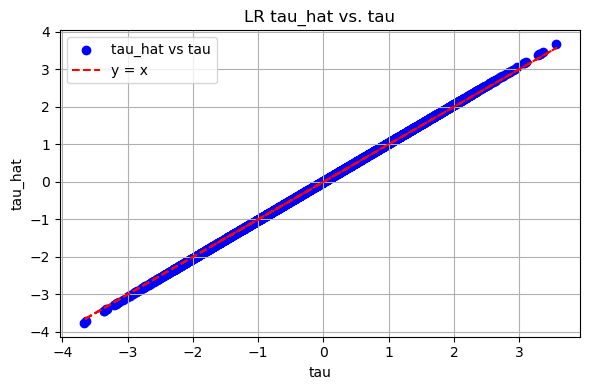

In [49]:
data_lr = data.copy()
data_lr['X1*Z'] = data_lr['X1'] * data_lr['Z'] #Setting interaction term
lr_xfit = data_lr[['X1', 'Z', 'X1*Z']]

lr = LinearRegression() #Fit linear regression
lr.fit(lr_xfit, data_lr['Y'])

bz = lr.coef_[1]
bzx = lr.coef_[2]

tau_hat_lr = bz + bzx*data['X1']


mse_lr, bias_lr, r2_lr = metrics.evaluate(tau, tau_hat_lr)

metrics.tau_plot(tau, tau_hat_lr, 'LR tau_hat vs. tau')

In [50]:
print(tau_hat_lr)

0       0.425534
1      -1.038958
2       1.334523
3      -1.101497
4      -1.254519
          ...   
9995    0.074111
9996    0.594235
9997    0.192178
9998    1.134504
9999   -1.701694
Name: X1, Length: 10000, dtype: float64


In [51]:
print(f'LR metrics:\nMse: {mse_lr}\nBias: {bias_lr}\nR2 {r2_lr}')

LR metrics:
Mse: 0.0007048516794913227
Bias: -0.010004015259472176
R2 0.9993021114359468


## X-Learner

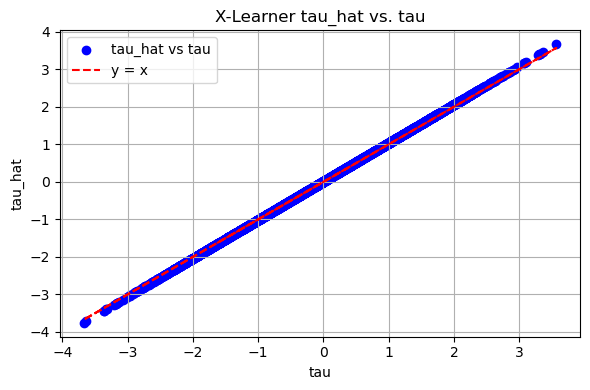

In [52]:
est = XLearner(models=LinearRegression())
est.fit(y, T, X=X)
tau_hat_x = est.effect(X)

mse_x, bias_x, r2_x = metrics.evaluate(tau, tau_hat_x)
metrics.tau_plot(tau, tau_hat_x, 'X-Learner tau_hat vs. tau')

In [53]:
print(f'X-learner metrics:\nMse: {mse_x}\nBias: {bias_x}\nR2 {r2_x}')

X-learner metrics:
Mse: 0.0007048516794912915
Bias: -0.010004015259472275
R2 0.9993021114359468


## S + T Learner

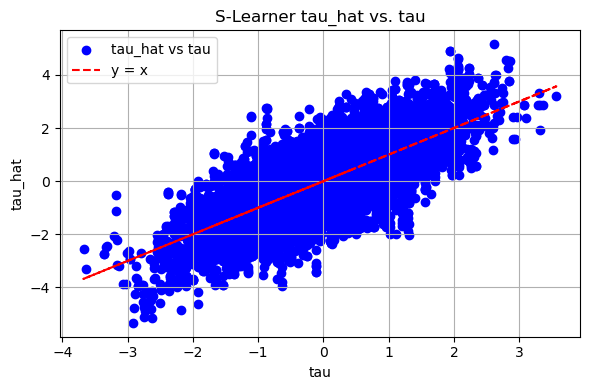

In [54]:
est = SLearner(overall_model=RandomForestRegressor())
est.fit(y, T, X=X)
tau_hat_s = est.effect(X)

mse_s, bias_s, r2_s = metrics.evaluate(tau, tau_hat_s)
metrics.tau_plot(tau, tau_hat_s, 'S-Learner tau_hat vs. tau')

In [55]:
print(f'S-learner metrics:\nMse: {mse_s}\nBias: {bias_s}\nR2 {r2_s}')

S-learner metrics:
Mse: 0.8882016399480998
Bias: -0.009221475550920242
R2 0.12057276001610984


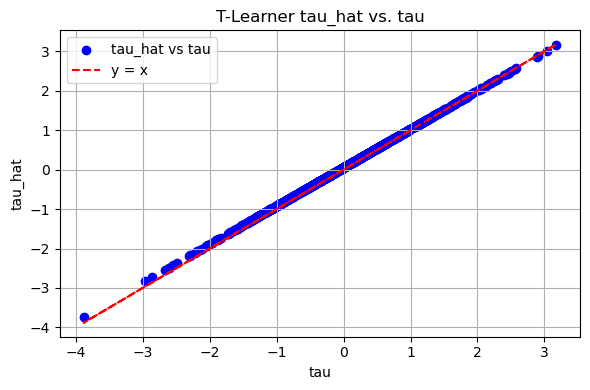

In [32]:
est = TLearner(models=LinearRegression())
est.fit(y, T, X=X)
tau_hat_t = est.effect(X)

mse_t, bias_t, r2_t = metrics.evaluate(tau, tau_hat_t)
metrics.tau_plot(tau, tau_hat_t, 'T-Learner tau_hat vs. tau')

In [33]:
print(f'S-learner metrics:\nMse: {mse_t}\nBias: {bias_t}\nR2 {r2_t}')

S-learner metrics:
Mse: 0.003644636848302164
Bias: -0.054551325072873476
R2 0.9961763114081501


## DR-Learner

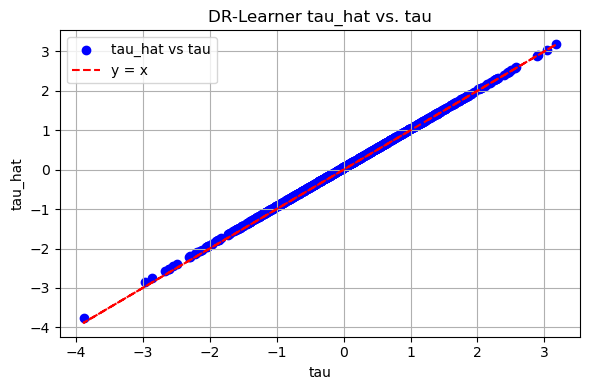

In [16]:
est = DRLearner()
est.fit(y, T, X=X, W=None)
tau_hat_dr = est.effect(X)

mse_dr, bias_dr, r2_dr = metrics.evaluate(tau, tau_hat_dr)
metrics.tau_plot(tau, tau_hat_dr, 'DR-Learner tau_hat vs. tau')

In [17]:
print(f'DR-learner metrics:\nMse: {mse_dr}\nBias: {bias_dr}\nR2 {r2_dr}')

DR-learner metrics:
Mse: 0.003485080752377612
Bias: -0.05661615638010556
R2 0.9963437060894696


## Causal Forest

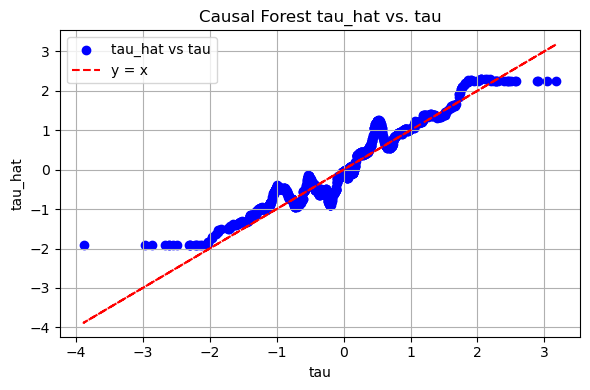

In [18]:
est = CausalForestDML(discrete_treatment=True)
est.fit(y, T, X=X, W=None)
tau_hat_cf = est.effect(X)

mse_cf, bias_cf, r2_cf = metrics.evaluate(tau, tau_hat_cf)
metrics.tau_plot(tau, tau_hat_cf, 'Causal Forest tau_hat vs. tau')

In [19]:
print(f'Causal Forest metrics:\nMse: {mse_cf}\nBias: {bias_cf}\nR2 {r2_cf}')

Causal Forest metrics:
Mse: 0.08721522012265212
Bias: -0.0690038699443272
R2 0.9085001178172224
